<a href="https://colab.research.google.com/github/somyaranjan26/DeepLearning/blob/master/VGG19_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Use this Notebook on Google Colab Free GPU**
Go to Google Drive, upload this notebook and dataset folders. Rigth click notebook, choose **Open with -> Google Colab**
<br>
To activate GPU in Colab, go to **Runtime -> Change Runtime Type**. Under **Hardware accelerator** choose **GPU**

### Connect to Google Drive to access Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Deep Learning Internship/Training'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Deep Learning Internship/Training


### Import all dependencies

In [2]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Define Few Parameters

In [3]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 100
batch_size = 32

#define paths
pneumonia_path = 'Pneumonia645'
nonpneumonia_path = 'Normal645'

# Use glob to grab images from path .jpg or jpeg
pneumonia_files = glob(pneumonia_path + '/*')
nonpneumonia_files = glob(nonpneumonia_path + '/*')

### Fetch Images and Class Labels from Files (This might take a while)

In [4]:
# Preparing Labels
pneumonia_labels = []
nonpneumonia_labels = []

pneumonia_images=[]
nonpneumonia_images=[]

import cv2 

for i in range(len(pneumonia_files)):
  image = cv2.imread(pneumonia_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  pneumonia_images.append(image)
  pneumonia_labels.append('Chest_Pneumonia')
for i in range(len(nonpneumonia_files)):
  image = cv2.imread(nonpneumonia_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  nonpneumonia_images.append(image)
  nonpneumonia_labels.append('Chest_NonPneumonia')

print(len(pneumonia_labels))
print(len(nonpneumonia_labels))

645
645


### Visualize First 40 Images from Data set

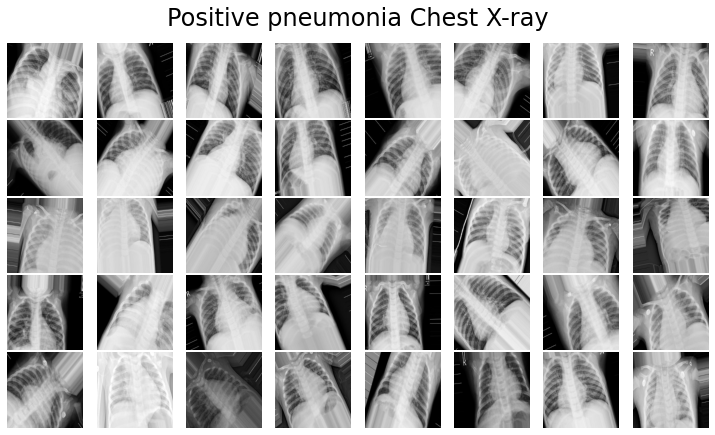

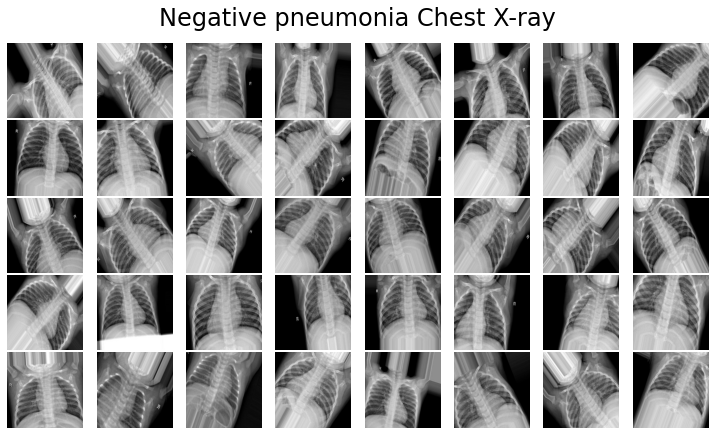

In [5]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(pneumonia_images, 'Positive pneumonia Chest X-ray')
plot_images(nonpneumonia_images, 'Negative pneumonia Chest X-ray')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [6]:
# Convert to array and Normalize to interval of [0,1]
pneumonia_images = np.array(pneumonia_images) / 255
nonpneumonia_images = np.array(nonpneumonia_images) / 255

### **Train Test Split**

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
pneumonia_x_train, pneumonia_x_test, pneumonia_y_train, pneumonia_y_test = train_test_split(
    pneumonia_images, pneumonia_labels, test_size=0.2)
nonpneumonia_x_train, nonpneumonia_x_test, nonpneumonia_y_train, nonpneumonia_y_test = train_test_split(
    nonpneumonia_images, nonpneumonia_labels, test_size=0.2)


X_train = np.concatenate((nonpneumonia_x_train, pneumonia_x_train), axis=0)
X_test = np.concatenate((nonpneumonia_x_test, pneumonia_x_test), axis=0)
y_train = np.concatenate((nonpneumonia_y_train, pneumonia_y_train), axis=0)
y_test = np.concatenate((nonpneumonia_y_test, pneumonia_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

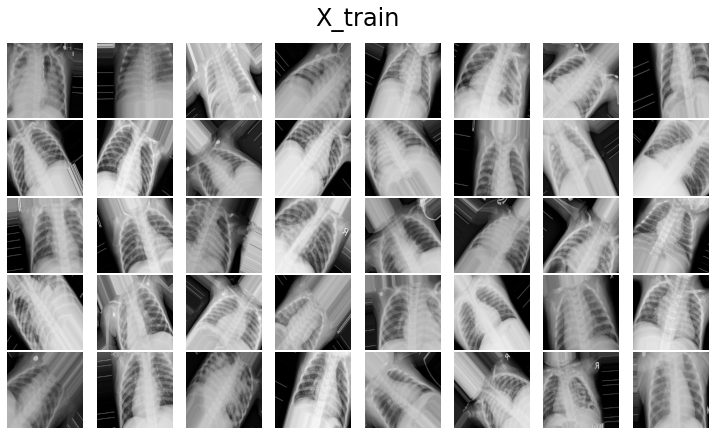

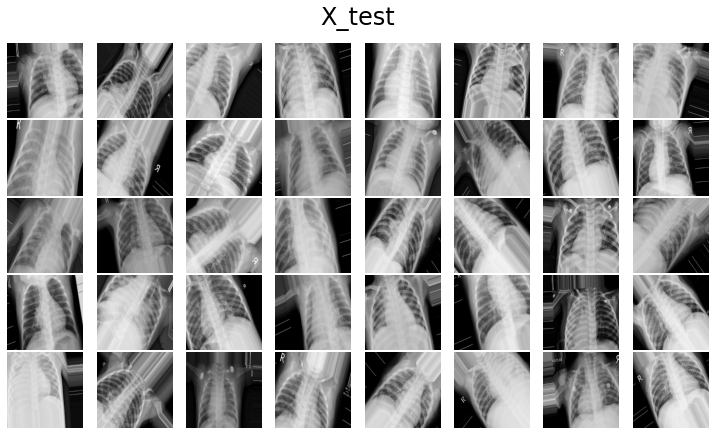

In [8]:
plot_images(pneumonia_x_train, 'X_train')
plot_images(pneumonia_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing Pneumonia and NonPneumonia for X_train and X_test

### **Building and Visualizing model**

In [9]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

80142336/80134624 [==============================] - 1s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### **Image Augmentation**
To train on images at different positions, angles, flips, etc

In [11]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [12]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=50)

Epoch 1/50
33/32 [==============================] - 47s 1s/step - loss: 0.8183 - accuracy: 0.6676 - val_loss: 0.3120 - val_accuracy: 0.8643
Epoch 2/50
33/32 [==============================] - 47s 1s/step - loss: 0.4354 - accuracy: 0.8169 - val_loss: 0.2552 - val_accuracy: 0.8876
Epoch 3/50
33/32 [==============================] - 47s 1s/step - loss: 0.3956 - accuracy: 0.8295 - val_loss: 0.2361 - val_accuracy: 0.9147
Epoch 4/50
33/32 [==============================] - 47s 1s/step - loss: 0.5005 - accuracy: 0.8110 - val_loss: 0.2428 - val_accuracy: 0.9070
Epoch 5/50
33/32 [==============================] - 47s 1s/step - loss: 0.3729 - accuracy: 0.8537 - val_loss: 0.2205 - val_accuracy: 0.9186
Epoch 6/50
33/32 [==============================] - 47s 1s/step - loss: 0.3239 - accuracy: 0.8731 - val_loss: 0.2773 - val_accuracy: 0.8953
Epoch 7/50
33/32 [==============================] - 47s 1s/step - loss: 0.3518 - accuracy: 0.8731 - val_loss: 0.2151 - val_accuracy: 0.9147
Epoch 8/50
33/32 [==

In [13]:
model.save('vgg_pneumonia100.h5')

In [14]:
model.save_weights('vggweights_pneumonia100.hdf5')

In [15]:
model = load_model('vgg_pneumonia100.h5')

### **Making Predicions**

In [16]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

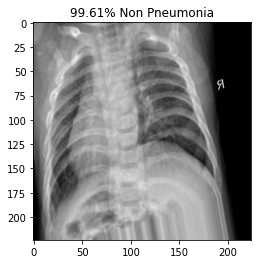

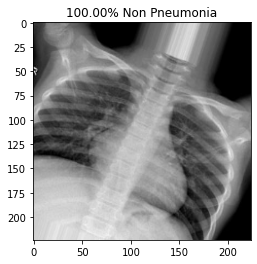

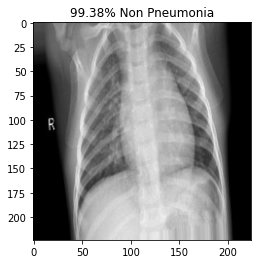

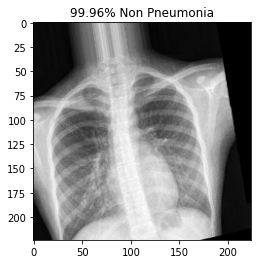

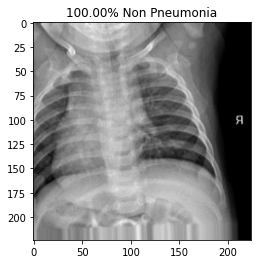

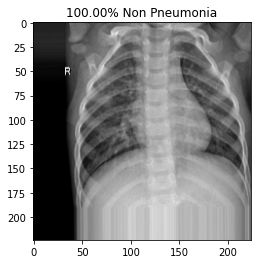

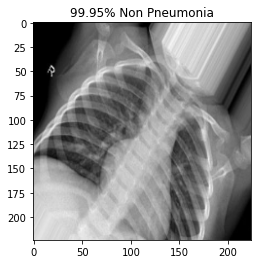

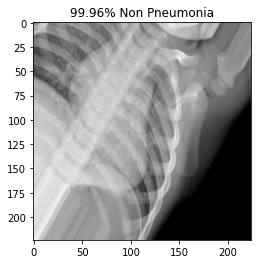

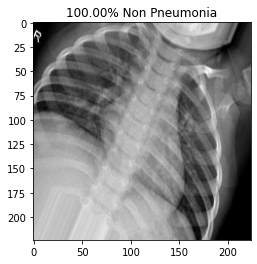

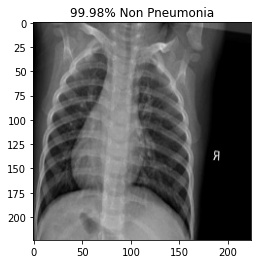

In [17]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% Pneumonia')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Non Pneumonia')
  plt.imshow(X_test[index])
  plt.show()

In [18]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

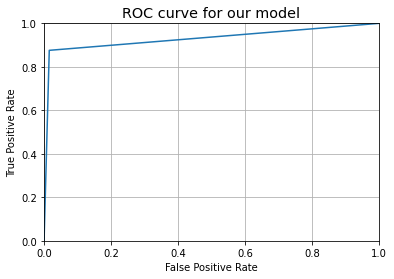

In [19]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


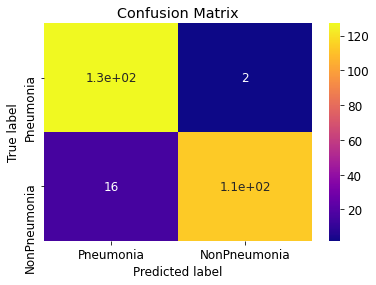

Confusion Matrix with Normalized Values


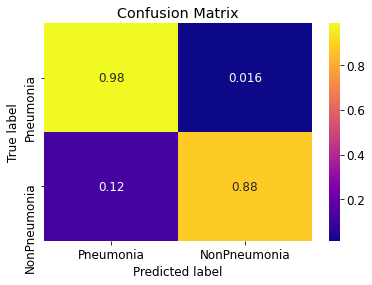

In [20]:
def plot_confusion_matrix(normalize):
  classes = ['Pneumonia','NonPneumonia']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       129
           1       0.98      0.88      0.93       129

    accuracy                           0.93       258
   macro avg       0.94      0.93      0.93       258
weighted avg       0.94      0.93      0.93       258



### **Accuracy and Loss Plots**

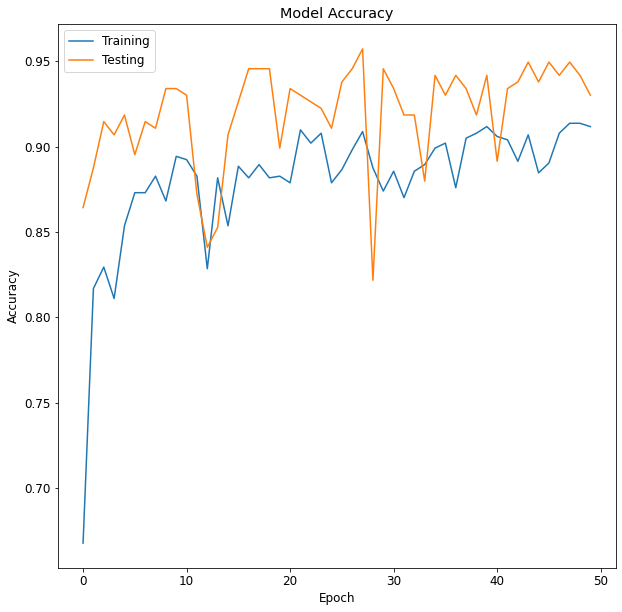

In [22]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_pneumonia_accuracy.png')
plt.show()


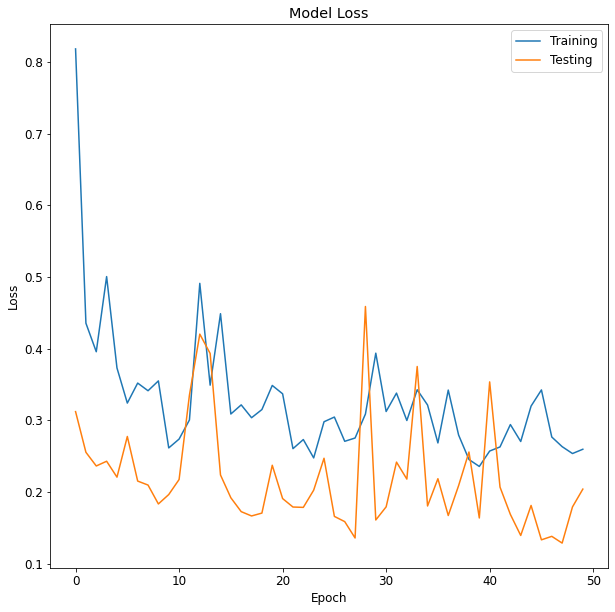

In [23]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_pneumonia_loss.png')
plt.show()